In [48]:
import pyart
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rc
import sys
from matplotlib.ticker import MultipleLocator
sys.path.append('/Users/robbyfrost/Documents/MS_Project/TurbTor_Radar/')
from functions import *
import os

# plotting set up
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'
rc('font', family='sans-serif')
rc('font', weight='normal', size=15)
rc('figure', facecolor='white')

Read all time steps

In [49]:
dir_rad = '/Users/robbyfrost/Documents/MS_Project/data/OU-PRIME/20100510/proc/'

rall = []
for file in sorted(os.listdir(dir_rad)):
    if file.startswith('nexrad'):
        file_path = f"{dir_rad}/{file}"
        radar = pyart.io.read(file_path)
        rall.append(radar)

Calculate vorticity on each sweep

In [50]:
vall = []
for i, radar in enumerate(rall):
    vortz_full = np.zeros_like(radar.fields['velocity']['data'])
    for swp in range(radar.nsweeps):
        # extract sweep
        radswp = radar.extract_sweeps([swp])
        # extract fields
        az = radswp.azimuth['data']
        el = radswp.elevation['data']
        r = radswp.range['data']
        vr = radswp.fields['velocity']['data']
        # smooth vr
        vr_da = xr.DataArray(vr, dims=["az", "r"])
        vr = vr_da.rolling(az=3,r=3, center=True).mean().values
        # calculate vorticity
        vortz = np.zeros_like(vr)
        vortz[1:, :] = ( (vr[1:,:] - vr[:-1,:]) / (np.deg2rad(az[1:]) - np.deg2rad(az[:-1]))[:,np.newaxis] ) * (1 / r)
        # add to sweep
        vortz_field = {
            'data': vortz,
            'units': '/s',
            'long_name': 'Inferred Vertical Vorticity',
            'standard_name': 'Inferred vertical vorticity',
        }
        radswp.add_field('vortz', vortz_field)
        # combine sweeps
        if swp == 0:
            azidx = az.size
            vortz_full[:azidx,:] = vortz
        else:
            vortz_full[azidx:azidx+az.size,:] = vortz
            azidx = azidx + az.size
    # add to radar object
    vortz_full_field = {
        'data': vortz_full,
        'units': '/s',
        'long_name': 'Inferred Vertical Vorticity',
        'standard_name': 'Inferred vertical vorticity',
    }
    radar.add_field('vortz', vortz_full_field)

### Lowest sweep: Reflectivity (left), radial velocity (center), and vertical vorticity (right)

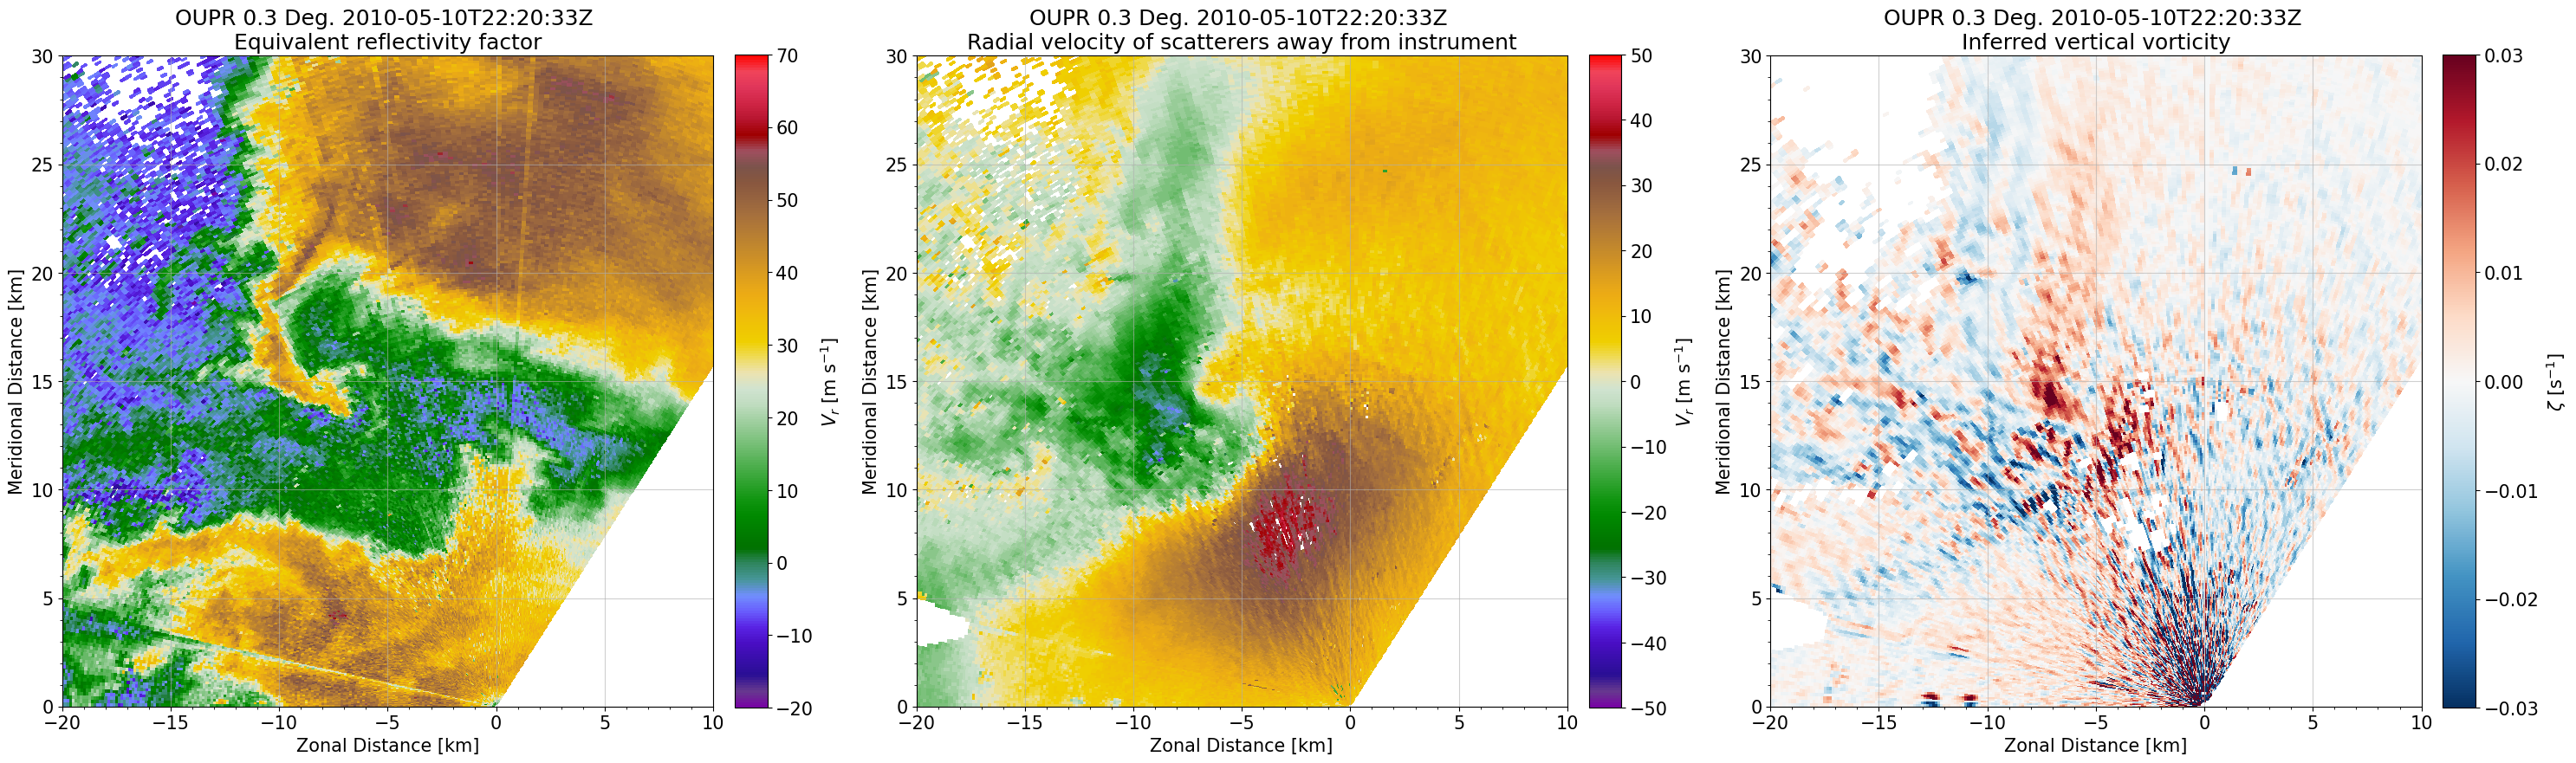

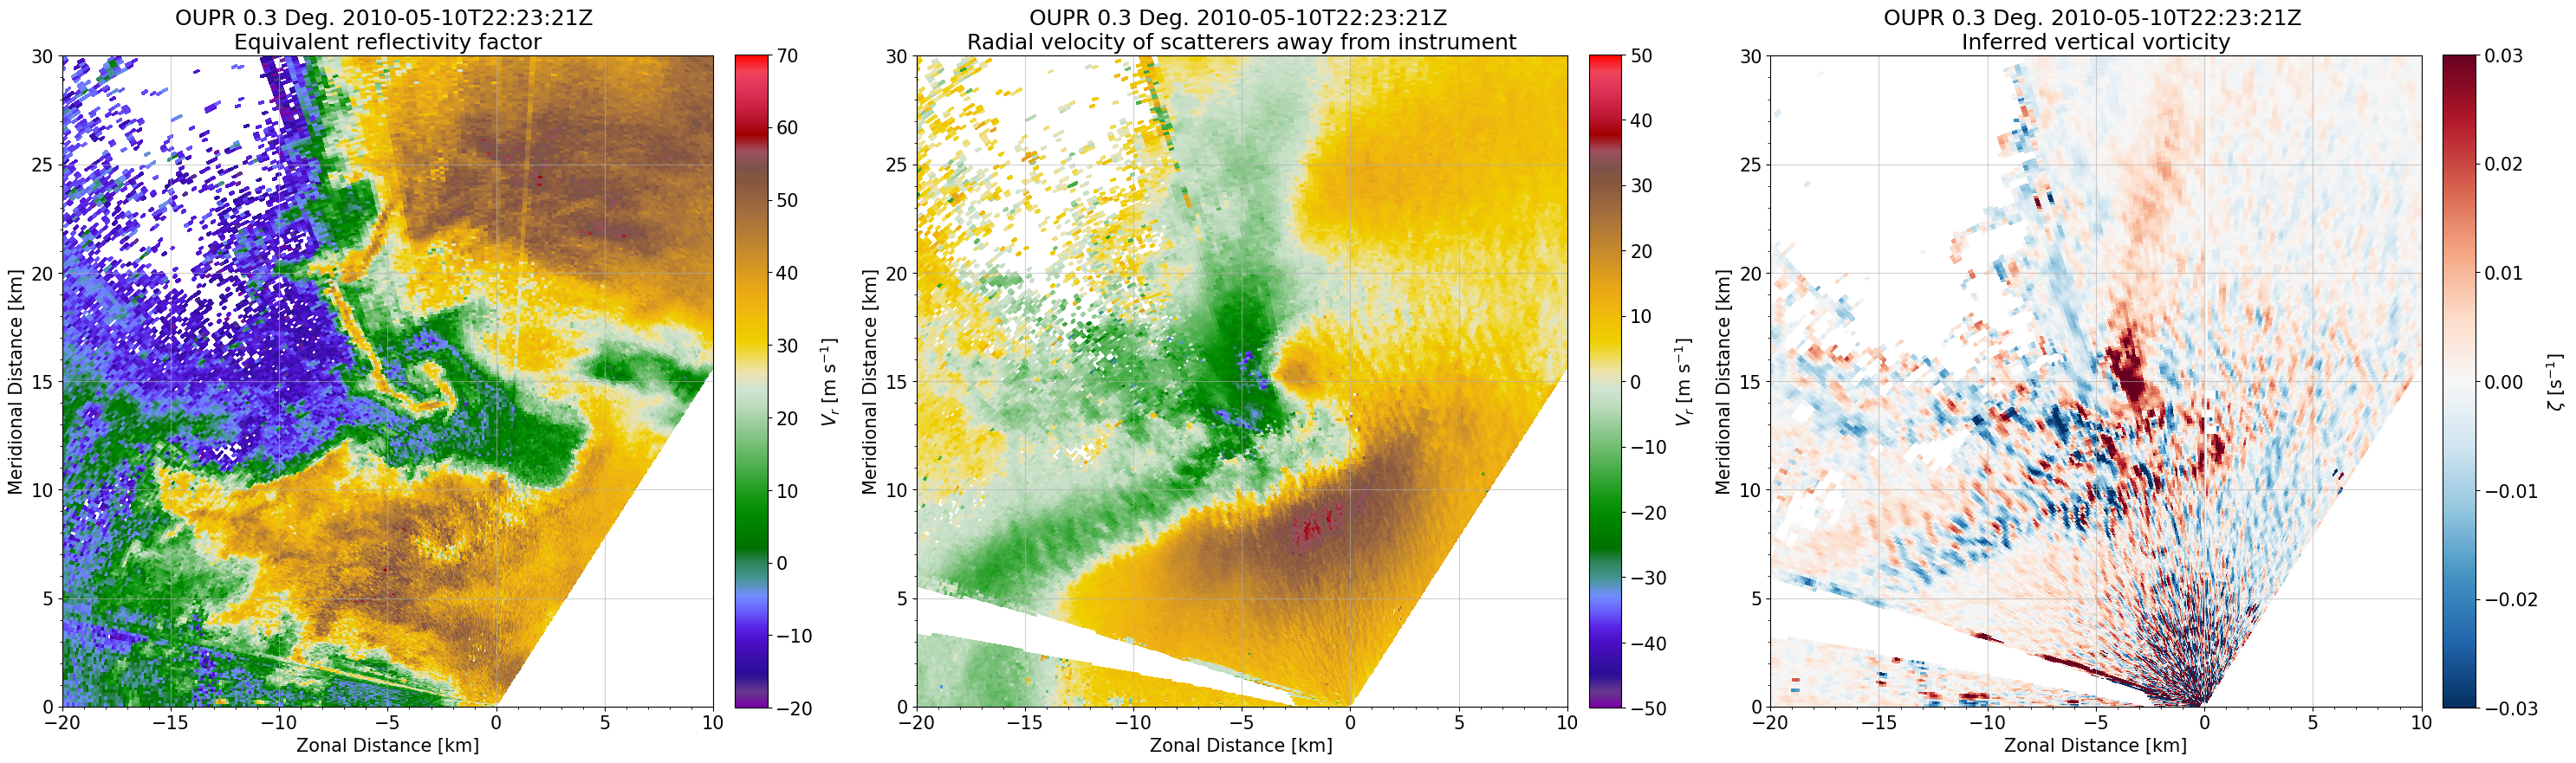

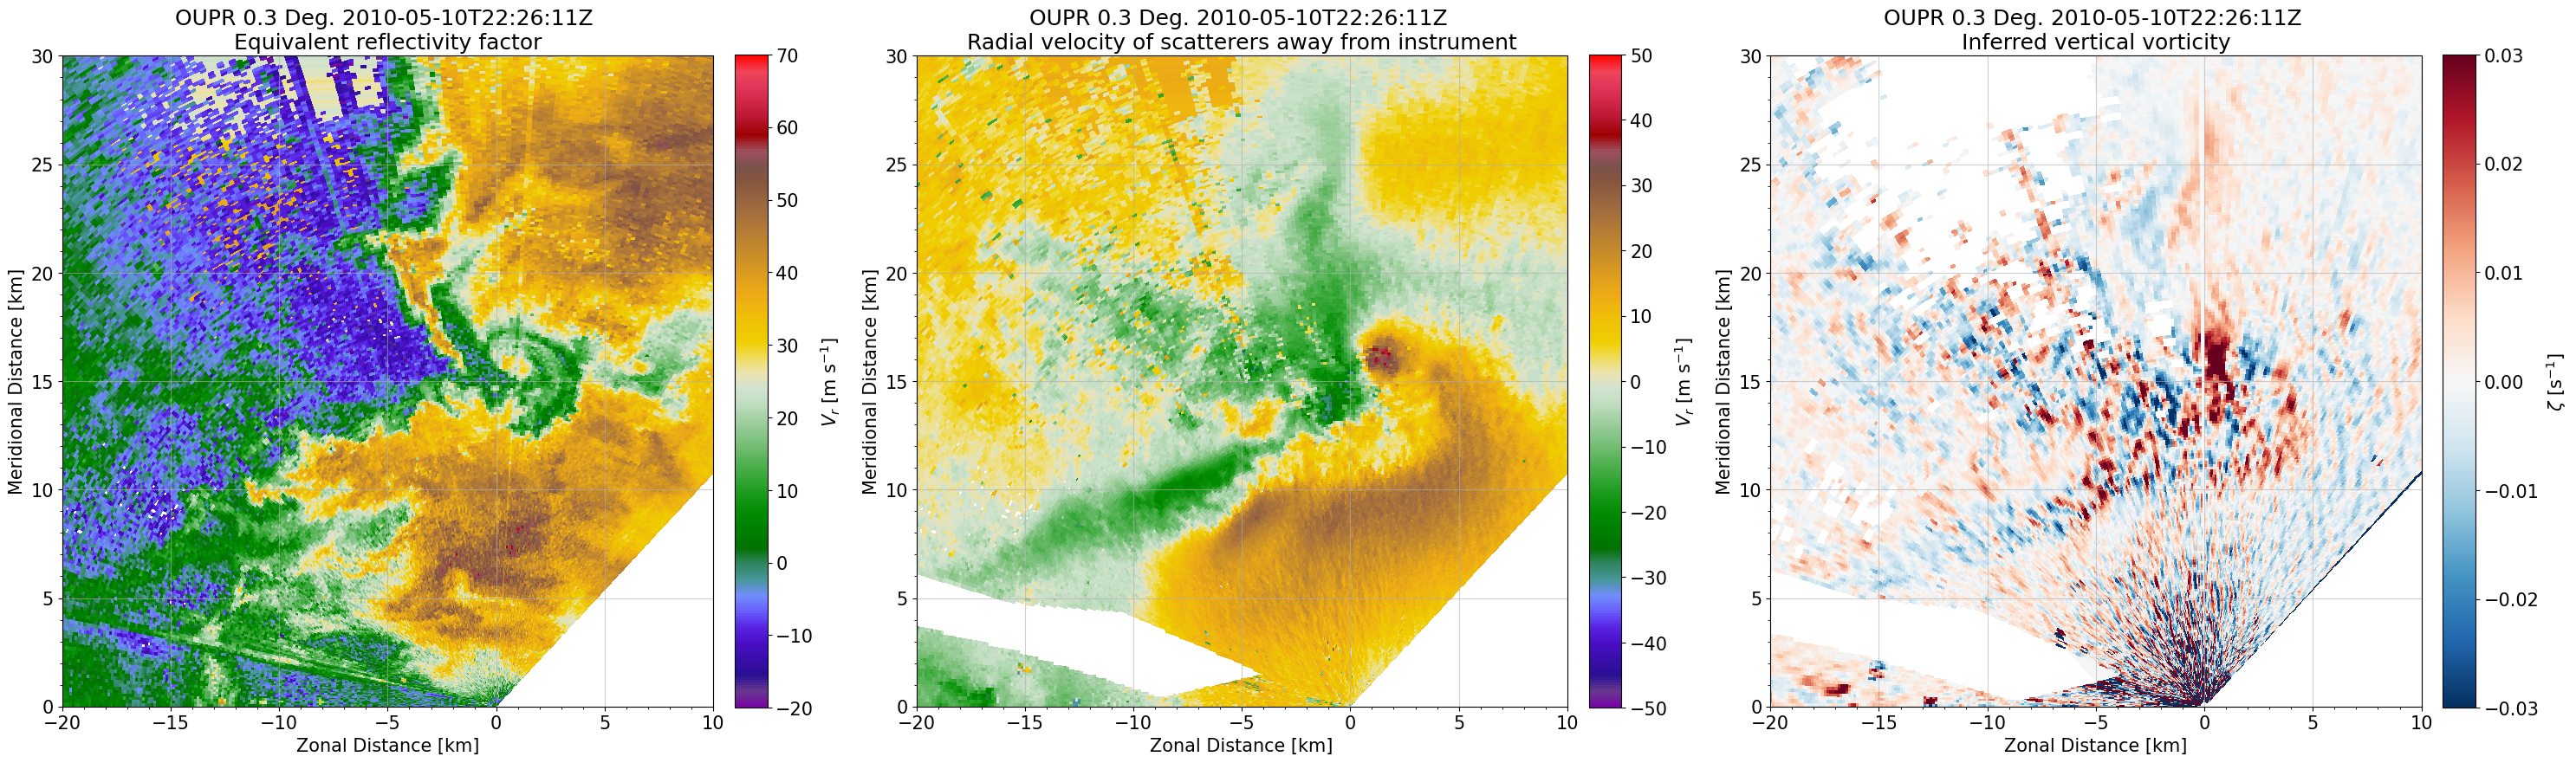

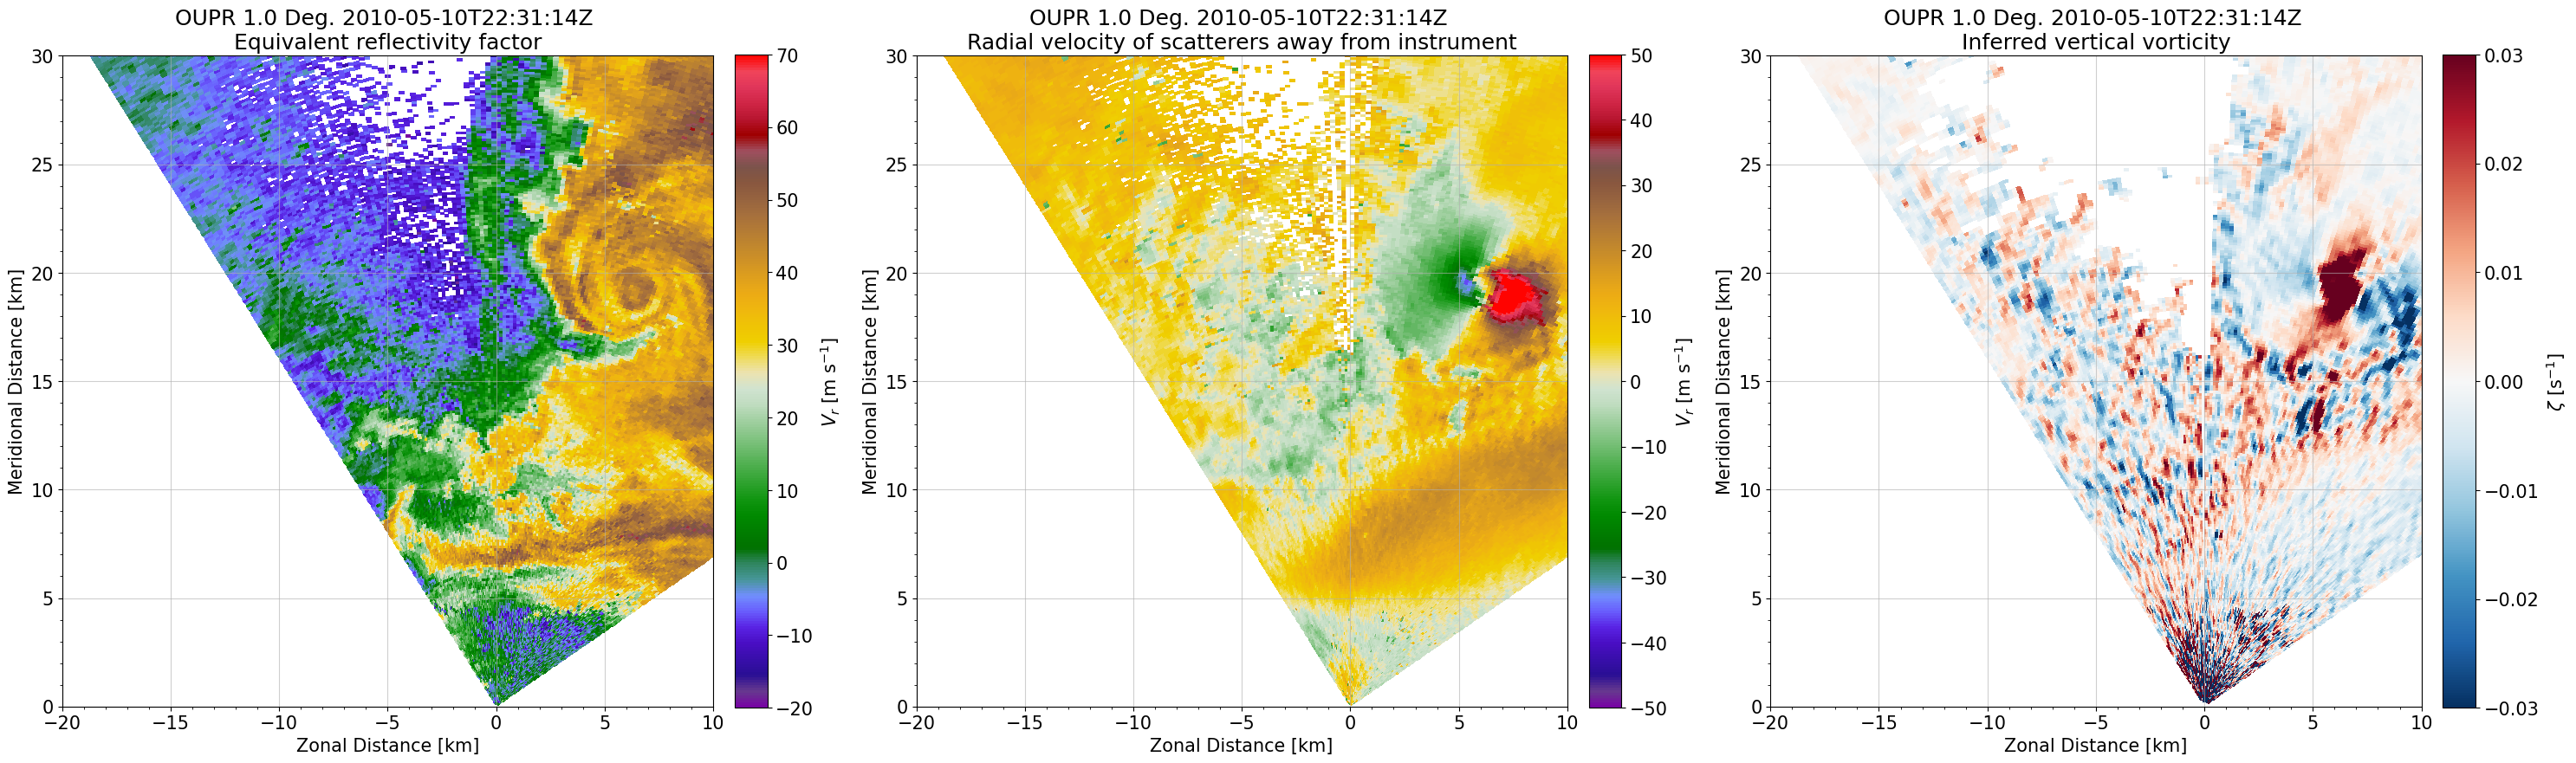

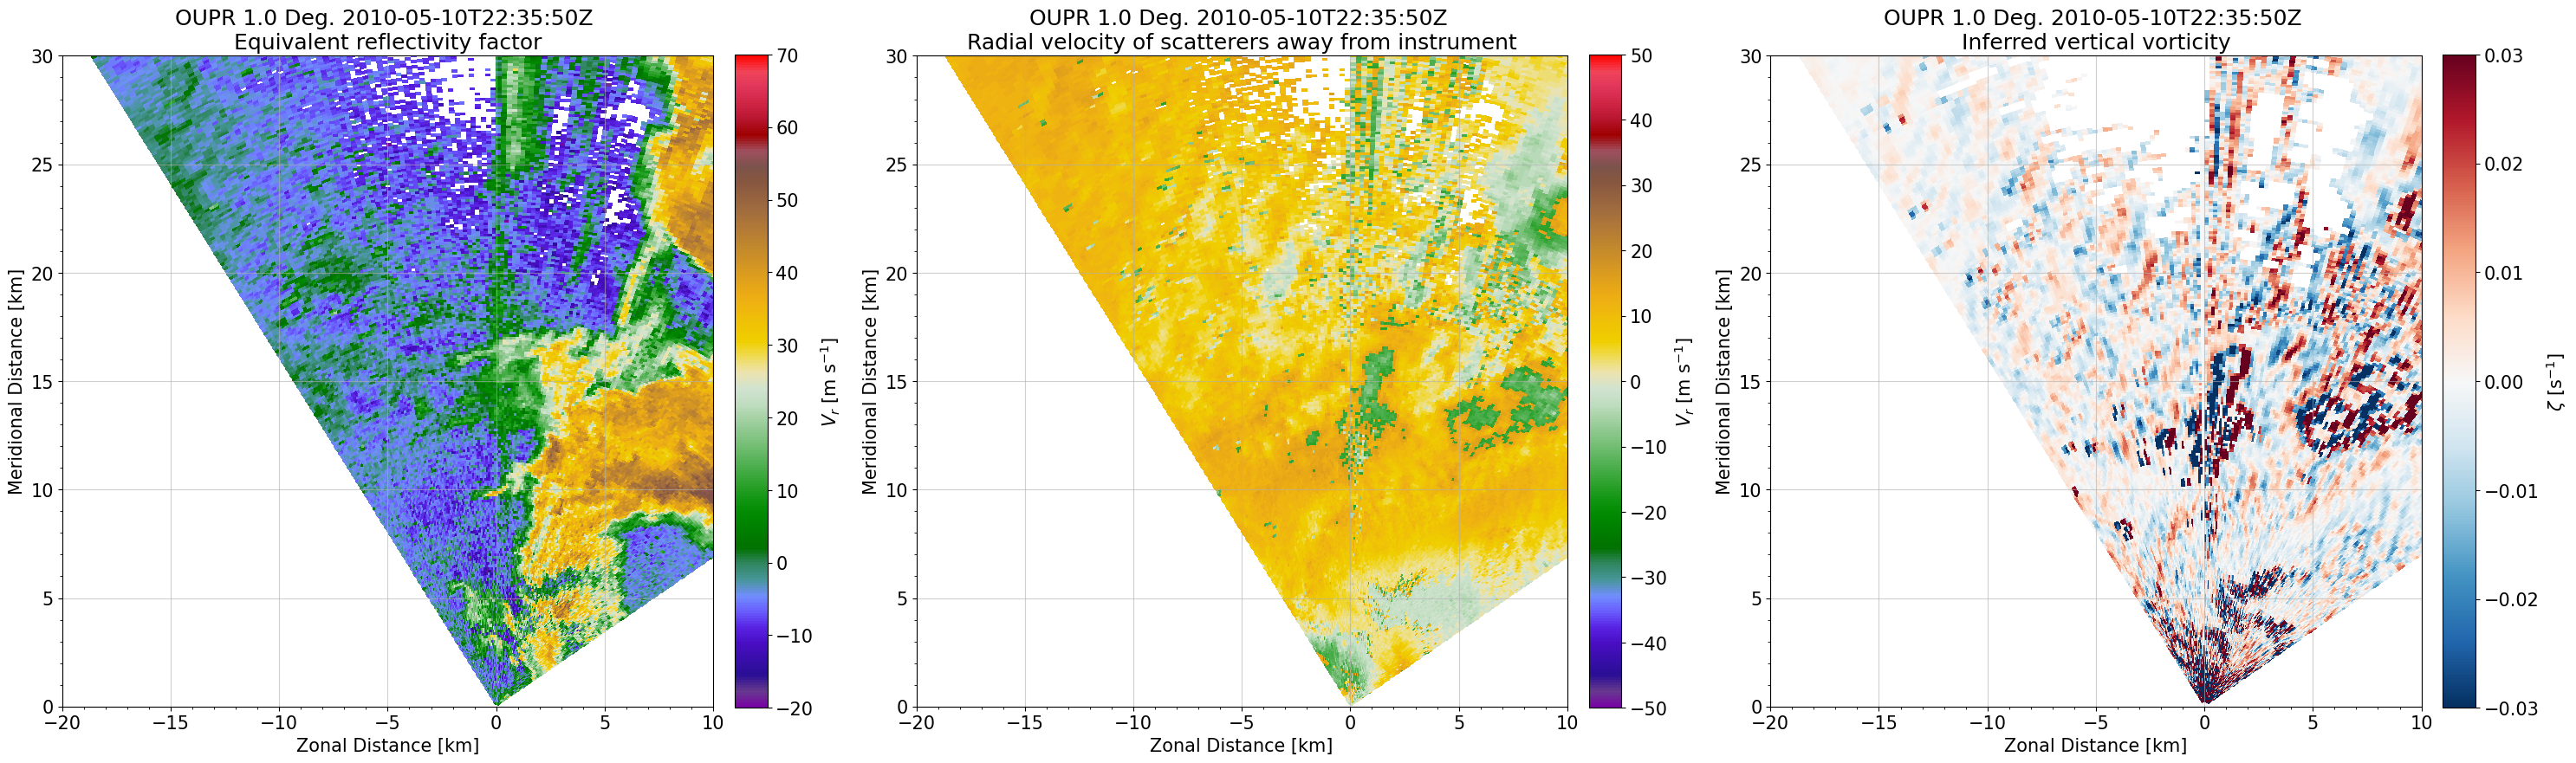

In [51]:
swp = 0
for i, radar in enumerate(rall):

    display = pyart.graph.RadarDisplay(radar.extract_sweeps([swp]))

    fig, ax = plt.subplots(figsize=(30, 10), ncols=3)

    # reflectivity
    vmin, vmax = -20, 70
    display.plot_ppi('reflectivity', ax=ax[0], 
                    vmin=vmin, vmax=vmax,
                    cmap="Carbone42",
                    colorbar_flag=False,
                    title_use_sweep_time=True,
                    axislabels_flag=False)
    cbar1 = fig.colorbar(display.plots[0], ax=ax[0], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
    cbar1.set_label("$V_r$ [m s$^{-1}$]")
    cbar1.set_ticks(np.arange(vmin, vmax + 0.001, 10))

    # radial velocity
    vmin, vmax = -50, 50
    display.plot_ppi('velocity', ax=ax[1], 
                    vmin=vmin, vmax=vmax,
                    cmap="Carbone42",
                    colorbar_flag=False,
                    title_use_sweep_time=True,
                    axislabels_flag=False)
    cbar1 = fig.colorbar(display.plots[1], ax=ax[1], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
    cbar1.set_label("$V_r$ [m s$^{-1}$]")
    cbar1.set_ticks(np.arange(vmin, vmax + 0.001, 10))

    # inf vertical vorticity
    vmin, vmax = -0.03, 0.03
    display.plot_ppi('vortz', ax=ax[2], 
                    vmin=vmin, vmax=vmax,
                    cmap="RdBu_r", 
                    colorbar_flag=False,
                    title_use_sweep_time=True,
                    axislabels_flag=False)
    # display.plot_range_rings(r[ridx]/1e3, ax=ax[2], ls='--', lw=1, col='black')
    cbar1 = fig.colorbar(display.plots[2], ax=ax[2], aspect=20, pad=0.03, fraction=0.06, shrink=0.79)
    cbar1.set_label("$\\zeta$ [s$^{-1}$]")
    cbar1.set_ticks(np.arange(vmin, vmax+0.001, 0.01))

    # # title
    # scan_time = radar.time['units'].split(' ')[-1]
    # elevation_angle = radar.fixed_angle['data'][swp]
    # fig.suptitle(f"{scan_time}, Elevation = {elevation_angle:.2f}°", fontsize=30, fontweight='bold', y=0.95)

    for iax in ax:
        iax.set_aspect('equal')
        iax.set_xlim(-20,10)
        iax.xaxis.set_major_locator(MultipleLocator(5))
        iax.xaxis.set_minor_locator(MultipleLocator(1))
        iax.set_xlabel("Zonal Distance [km]")
        iax.set_ylim(0,30)
        iax.yaxis.set_major_locator(MultipleLocator(5))
        iax.yaxis.set_minor_locator(MultipleLocator(1))
        iax.set_ylabel("Meridional Distance [km]")
        iax.grid(alpha=0.6)

    fig.tight_layout()
    plt.show()
    plt.close(fig)